### Task
Implement a python class for matching features detected with the class created on exercise 1.  The class should support matching of all the features types you created on exercise 1.

In [1]:
import numpy as np
import cv2 as cv
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 300

#### Feature Extractors

In [2]:
class FeatureExtractor(ABC):
    def __init__(self, img_path, max_points):
        # Loads image to memory
        self.original_img = cv.imread(img_path)
        
        # Transforms image to grayscale
        self.gray_img = cv.cvtColor(self.original_img,cv.COLOR_BGR2GRAY)
        
        self.kp = None
        self.des = None
        self.max_points = max_points
        
    @abstractmethod
    def run(self):
        pass

    def plot_key_points(self, title):
        if self.kp is None:
            raise RuntimeError('''It's necessary to extract the features (.run method)
                                before ploting the keypoints''')
        
        key_points_img = self.original_img.copy()
        cv.drawKeypoints(self.original_img,self.kp, key_points_img)
        key_points_img = cv.cvtColor(key_points_img, cv.COLOR_BGR2RGB)
        plt.imshow(key_points_img)
        plt.title(title)
        plt.axis('off')
        plt.show()

class SIFTFeatureExtractor(FeatureExtractor):
    def __init__(self, img_path, max_points=1000):
        super().__init__(img_path, max_points)
    
    def run(self):
        sift = cv.SIFT_create(nfeatures=self.max_points)
        self.kp, self.des = sift.detectAndCompute(self.gray_img,None)
        
        return self.kp, self.des

#Obs: The SURF Feature extractor needs a license
class SURFFeatureExtractor(FeatureExtractor):
    def __init__(self, img_path, max_points = 1000, hessian_thresshold=400):
        super().__init__(img_path, max_points)
        self.hessian_tresshold = hessian_thresshold
    
    def run(self):
        surf = cv.xfeatures2d.SURF_create(self.hessian_tresshold,nfeatures=self.max_points)
        self.kp, self.des = surf.detectAndCompute(self.gray_img,None)

        return self.kp, self.des
    
    def set_hessian_thresshold(self, thresshold):
        self.hessian_tresshold = thresshold

class BRIEFFeatureExtractor(FeatureExtractor):
    def __init__(self, img_path):
        super().__init__(img_path, max_points=None)
    
    def run(self):
        # Initiate FAST detector
        star = cv.xfeatures2d.StarDetector_create()
        
        # Initiate BRIEF extractor
        brief = cv.xfeatures2d.BriefDescriptorExtractor_create()
        
        # find the keypoints with STAR
        kp = star.detect(self.gray_img,None)
        
        # compute the descriptors with BRIEF
        self.kp, self.des = brief.compute(self.gray_img, kp)

        return self.kp, self.des

class ORBFeatureExtractor(FeatureExtractor):
    def __init__(self, img_path, max_points=1000):
        super().__init__(img_path,max_points)
    
    def run(self):
        # Initiate ORB detector
        orb = cv.ORB_create(nfeatures=self.max_points)
        
        # find the keypoints with ORB
        kp = orb.detect(self.gray_img,None)
        
        # compute the descriptors with ORB
        self.kp, self.des = orb.compute(self.gray_img, kp)

        return self.kp, self.des
    
class AKAZEFeatureExtractor(FeatureExtractor):
    def __init__(self, img_path, max_points=1000):
        super().__init__(img_path, max_points)
    
    def run(self):
        akaze = cv.AKAZE_create(max_points=self.max_points)

        self.kp, self.des = akaze.detectAndCompute(self.gray_img, None)

        return self.kp, self.des


#### Matching Algorithm

In [ ]:
class BruteForceMatcher:
    def __init__(self, img1_path, img2_path, feature_extractor, number_of_matches):
        self.fe_1 = feature_extractor(img1_path)
        self.fe_2 = feature_extractor(img2_path)

        # create BFMatcher object
        self.bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

        self.number_of_matches = number_of_matches
        self.matches = None
        

    def run(self):

        _, des_1 = self.fe_1.run()
        _, des_2 = self.fe_2.run()

        # Match descriptors.
        all_matches = self.bf.match(des_1,des_2)
        # Sort them in the order of their distance.
        self.matches = sorted(all_matches, key = lambda x:x.distance)[:self.number_of_matches]

    def plot_matches(self, title):
        if self.matches is None:
            raise RuntimeError('''It's necessary to extract and match the features (.run method)
                                before ploting the matched keypoints''')
        
        img3 = cv.drawMatches(self.fe_1.original_img,self.fe_1.kp,
                              self.fe_2.original_img,self.fe_2.kp,
                              self.matches,None,
                              flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        img3 = cv.cvtColor(img3, cv.COLOR_BGR2RGB)
        plt.imshow(img3)
        plt.title(title)
        plt.axis('off')
        plt.show()
        
        

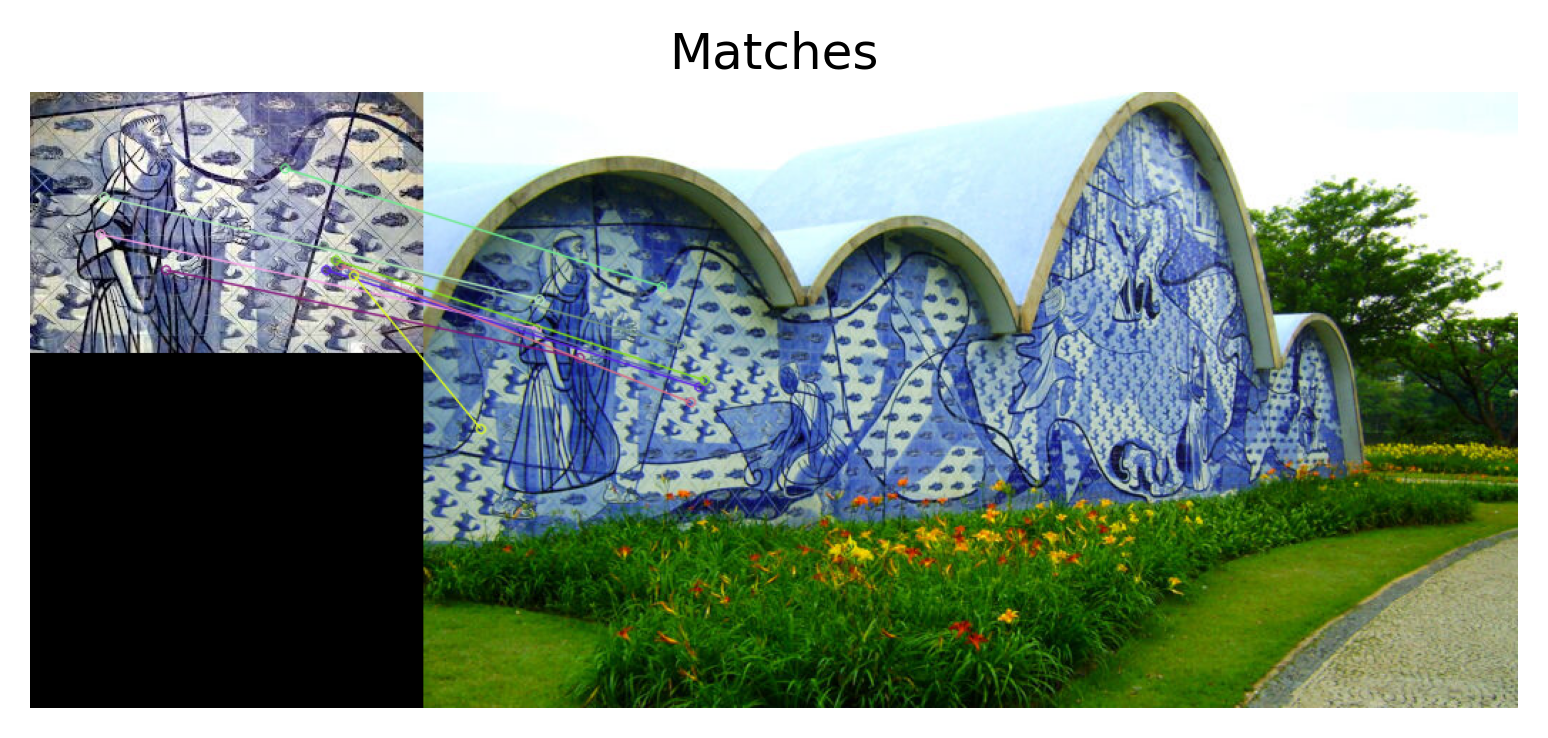

In [4]:
matcher = BruteForceMatcher(img1_path='./data/pampulha2.jpeg',
                            img2_path='./data/pampulha4.jpg',
                            feature_extractor=ORBFeatureExtractor,
                            number_of_matches=10)

matcher.run()
matcher.plot_matches(title="Matches")